# Face regconition using SVM and cross-validation

Classifying images is one of those areas in which relatively straightforward machine learning methods can already perform particularly well.

In this exercise you will produce code that will recognize people from images of their faces using support vector machines and cross-validation.

In [147]:
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")

## 1. Load the dataset 

In [148]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [149]:
faces

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     

## 2. Analyze the data

#### First, discover the dataset:

In [150]:
X, y = faces['data'], faces['target']
print(f'Data shape: {X.shape}')
print(f'Label shape: {y.shape}')

Data shape: (400, 4096)
Label shape: (400,)


In [151]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)

dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)


In [152]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [153]:
data = faces['data']
target = faces['target']
image = faces['images']

#### Show image of 40 people in the dataset:

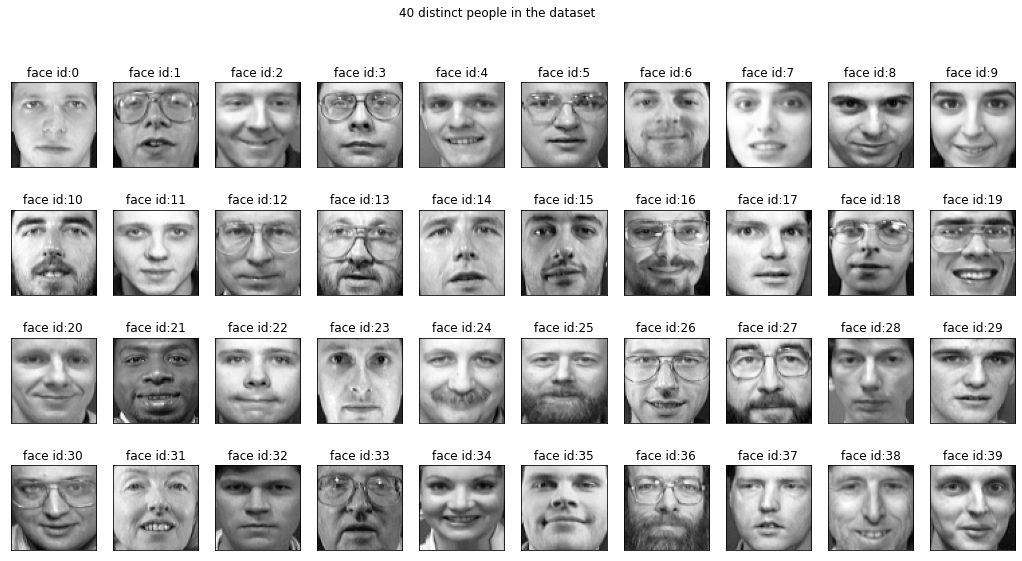

In [154]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, ax=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    ax=ax.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        ax[unique_id].imshow(images[image_index], cmap='gray')
        ax[unique_id].set_xticks([])
        ax[unique_id].set_yticks([])
        ax[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("40 distinct people in the dataset")

show_40_distinct_people(image, np.unique(target))

#### Show 10 images of 5 first targets in the dataset:

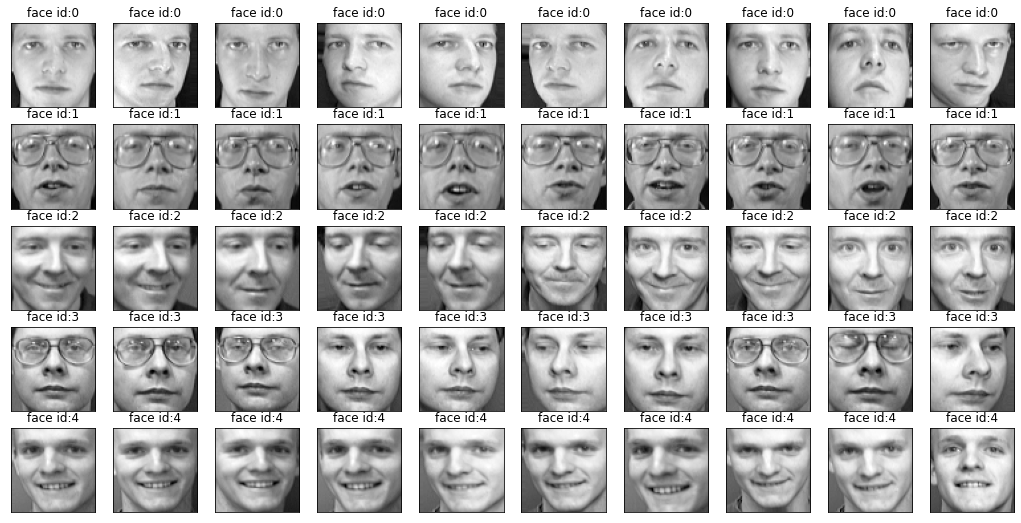

In [155]:
def show_10_images_of_n_subjects(images, n):
    cols=10# each subject has 10 distinct face images
    rows=(n*10)/cols #
    rows=int(rows)
    
    fig, ax=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    #axarr=axarr.flatten()
    
    for i in range(n):
        for j in range(cols):
            image_index=i*10 + j
            ax[i,j].imshow(images[image_index], cmap="gray")
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].set_title("face id:{}".format(i))
    
    
show_10_images_of_n_subjects(image,  5)

## 3. Modelling

Build training and testing sets:

In [156]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (280, 4096)
y_train shape:(280,)


### Classification

##### Define the classifier:

In [157]:
clf = SVC(kernel='linear')
print(clf)

SVC(kernel='linear')


In [158]:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, 
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

SVC(kernel='linear')

In [159]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

##### Classification result:

In [160]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {100 * accuracy:.2f}%")
num_correct = np.sum(y_test == y_pred)
print(f"Number of correctly classified samples: {num_correct}")
num_incorrect = len(y_test) - num_correct
print(f"Number of incorrectly classified samples: {num_incorrect}")

Accuracy score: 95.83%
Number of correctly classified samples: 115
Number of incorrectly classified samples: 5


In [161]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       0.33      1.00      0.50         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      0.60      0.75         5
          16       0.00      0.00      0.00         0
          17       1.00    

### Hyperparameter Tunning

##### GridSearchCV with SVC

In [162]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']} 

gridSearchCV=GridSearchCV(SVC(), param_grid,refit=True,verbose=2)
gridSearchCV.fit(X_train, y_train)

print(gridSearchCV.best_params_)
print(gridSearchCV.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.1s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

##### RandomizedSearchCV with SVC

In [163]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']} 
              
rand_search = RandomizedSearchCV(SVC(), param_grid, cv=5, n_iter=10, random_state=42) 
rand_search.fit(X_train, y_train) 

print(rand_search.best_params_)
print(rand_search.best_score_)

{'kernel': 'poly', 'gamma': 0.1, 'C': 100}
0.9285714285714286


### Cross validation

#####  Perform 5-fold cross-validation

In [164]:
def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator
    cv = KFold(5, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print(("Mean score: {0:.3f}").format(np.mean(scores), sem(scores)))

evaluate_cross_validation(svc, X_train, y_train, 5)

[0.92857143 0.96428571 0.92857143 0.94642857 0.91071429]
Mean score: 0.936
